The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


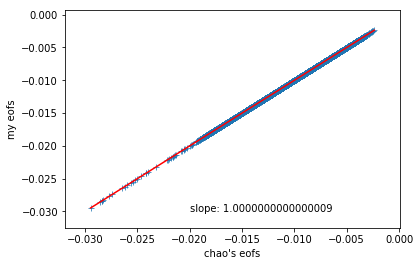

In [2]:
import sys
sys.path.append('../modules')

#from datacube import read_data
from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy import interpolate
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd

import glob



%load_ext autoreload
%autoreload 2

import feather



def read_data(data_path):
    """Load an ensemble of CanRCM4
    models into a single datacube.
    ------------------------------
    Args:
        data_path (Str): path to folder
            containing CanRCM4 ensemble
    Returns:
        ds (xarray Dataset): data cube of assembled ensemble models
            into a single variable.
    """
    #check_path(data_path)

    nc_list = np.asarray(glob.glob(data_path))
    test_file = xr.open_dataset(nc_list[0])
    actual_keys = set(test_file.variables).union(set(test_file.dims))
    #check_keys(actual_keys, {'rlat', 'rlon', 'lat', 'lon'})

    xr_list = [xr.open_dataset(path) for path in nc_list]
    ds = xr.concat(xr_list, 'run')
    actual_keys = set(ds.variables).union(set(ds.dims))
    #check_keys(actual_keys, {'rlat', 'rlon', 'lat', 'lon', 'run'})

     # find design value key so that it can
    # be renamed to dv for references throughout
    # climpyrical project
    for var in list(ds.variables):

        grids = ['rlon', 'rlat', 'lon', 'lat', 'time_bnds', 'bnds', 'time', 'rotated_pole']

        if var not in grids and var in ds.variables:
             ds = ds.rename({var: 'dv'})
        if 'time' in ds.keys():
            check_time(len(ds['time']))
            ds = ds.squeeze('time')

    return ds

import xarray as xr
#print(xr.open_dataset('/storage/data/projects/nrc/mapping_tool/data/pr_24hr_50yrs/pr24hr_50yrs_MLE_H09link_48grids_NAM-44_CCCma-CanESM2_historical-r1_r1i1p1_CCCma-CanRCM4_r2_1951-2016.nc'))
iens = flatten_ensemble(read_data('/storage/data/projects/nrc/mapping_tool/data/pr_24hr_50yrs/*.nc')['dv'].values)
iens = iens[:, ~np.isnan(iens)[0, ...]]
u, s, vT = np.linalg.svd(iens, full_matrices=False)

path = '../data/mpbasis.feather'
reofs = feather.read_dataframe(path).values

np.sort(reofs[0, ...]), np.sort(vT[0, ...])

vT[:4, ...].min()

x, y = np.sort(reofs[0, ...]), np.sort(vT[0, ...])

sns.scatterplot(x, 
                y, 
                palette="viridis",
                marker='+')

sns.lineplot(x, 
          x,
          color='r')

slope, intercept, r_value, p_value, std_err = linregress(x, y)

plt.text(-0.02, -0.03, "slope: {}".format(slope))

plt.ylabel('my eofs')
plt.xlabel('chao\'s eofs')
plt.savefig('../plots/svdcomparison')